# DPGP3 diversity analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
import sys
import os
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
import helpers as h

In [3]:
import matplotlib as mpl
single_col_width = 3.5
mpl.rcParams['font.size'] = 10
mpl.rcParams['axes.titlesize'] = 10
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] ='serif'

# Data

## Diversity

In [4]:
data_dir = '../data/DPGP3/minor_allele_counts/'
chromosomes = ['2L', '2R', '3L', '3R']
files = {c : data_dir + 'Chr' + c + '.mac.txt.gz' for c in chromosomes}
chrom_lengths = {'2L':23011544,
                 '2R':21146708,
                 '3L':24543557,
                 '3R':27905053}

In [5]:
data = {c : h.loadints(files[c], chrom_lengths[c], 2) for c in chromosomes}

In [6]:
# nobs = number (of genotypes) observed (i.e. ACGT, not N)
nobs = {c:data[c][:,0] for c in chromosomes}
# mac = minor allele count
mac = {c:data[c][:,1] for c in chromosomes}

## 4-fold degenerate sites

In [7]:
fourD_sites = pd.read_table('../data/dmel-4Dsites.txt.gz', header=None, names=['chr', 'pos'])
fourD_sites.head()

,chr,pos
0,YHet,316
1,YHet,340
2,YHet,352
3,YHet,364
4,YHet,373


In [8]:
#Convert from one-index to zero-index
fourD_pos = {chrom : np.array(fourD_sites.pos[fourD_sites.chr == chrom] - 1) for chrom in chromosomes}

In [9]:
print('Fraction of sites that are 4-fold degenerate:')
for chrom in chromosomes:
    print('{}\t{:.3f}'.format(chrom, len(fourD_pos[chrom]) / data[chrom].shape[0]))

Fraction of sites that are 4-fold degenerate:
2L	0.028
2R	0.032
3L	0.028
3R	0.030


# Coverage and diversity

In [10]:
# The boundaries of the "central" regions of each chromosome.
start = {'2L':int(1e6),
        '2R':int(6e6),
        '3L':int(1e6),
        '3R':int(10e6)}
end = {'2L':int(17e6),
        '2R':int(19e6),
        '3L':int(17e6),
        '3R':int(26e6)}

/Users/dpr/sandbox/multiplemergers/src/helpers.py:11: RuntimeWarning: divide by zero encountered in true_divide
  f = allele_counts / sample_size
/Users/dpr/sandbox/multiplemergers/src/helpers.py:11: RuntimeWarning: invalid value encountered in true_divide
  f = allele_counts / sample_size
/Users/dpr/sandbox/multiplemergers/src/helpers.py:12: RuntimeWarning: divide by zero encountered in true_divide
  return 2*f*(1-f) / (1 - (1/sample_size))
/Users/dpr/sandbox/multiplemergers/src/helpers.py:12: RuntimeWarning: invalid value encountered in true_divide
  return 2*f*(1-f) / (1 - (1/sample_size))
/Users/dpr/miniconda3/envs/mmc/lib/python3.5/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


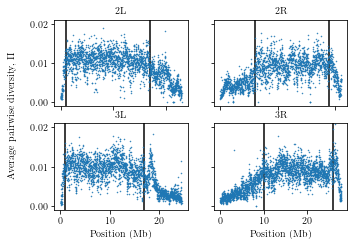

In [11]:
window_size = 10000

fig = plt.figure(figsize=(1.5*single_col_width, single_col_width))
for i, chrom in enumerate(chromosomes):
    n_w = chrom_lengths[chrom] // window_size
    pos = np.arange(n_w)*window_size / 1e6
    
    hascov = nobs[chrom] > 0
    hascov_w = np.sum(hascov[:n_w*window_size].reshape(n_w, window_size), axis=1)

    
    pi = h.pairwise_diversity(mac[chrom], nobs[chrom])
    pi_w = np.nansum(pi[:n_w*window_size].reshape(n_w, window_size), axis=1)
                             
    ax = plt.subplot(2,2,i+1)
    ax.plot(pos, pi_w/hascov_w, '.', ms=1, alpha=1)#, linestyle='steps-pre')
    ax.vlines([start[chrom]/1e6,end[chrom]/1e6], -0.001, 0.021)
    
    ax.set_ylim([-0.001, 0.021])

    ax.set_title(chrom)
    if i%2 != 0:
        ax.set_yticklabels([])
    if i >= 2:
        ax.set_xlabel('Position (Mb)')
    else:
        ax.set_xticklabels([])
fig.text(0,0.5, r'Average pairwise diversity, $\Pi$', rotation=90, va='center')
fig.savefig('../manuscript/figures/pi_vs_position.pdf')

# Called genotypes in the central regions

In [12]:
nobs_c = {c:nobs[c][start[c]:end[c]] for c in chromosomes}
mac_c = {c:mac[c][start[c]:end[c]] for c in chromosomes}

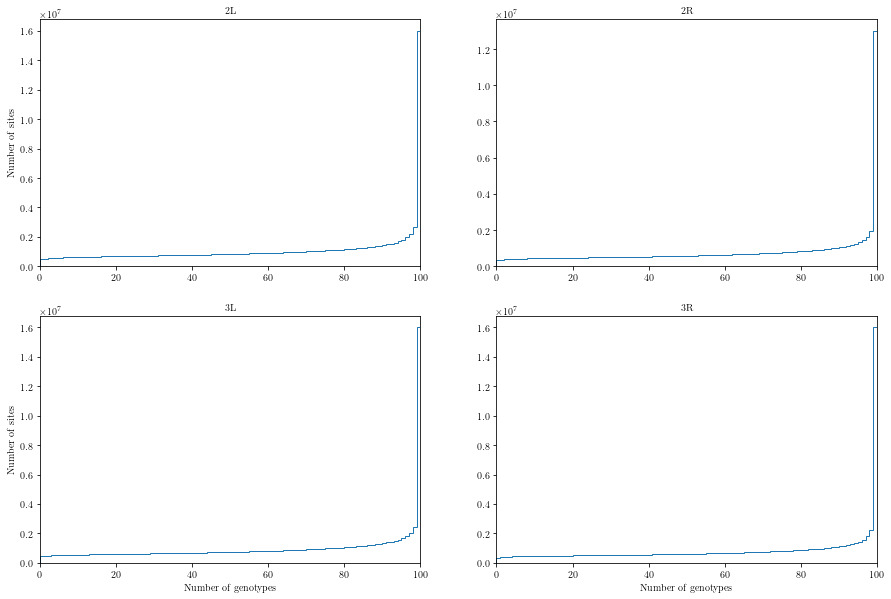

In [13]:
# Plot histograms of the number of alleles called at each site
plt.figure(figsize=(15,10))
for i, chrom in enumerate(chromosomes):
    plt.subplot(2,2,i+1)
    plt.hist(nobs_c[chrom], bins=np.arange(0,101,1), cumulative=True, histtype='step')
    plt.xlim([0,100])
    plt.title(chrom)
    if i%2 == 0:
        plt.ylabel('Number of sites')
    if i >= 2:
        plt.xlabel('Number of genotypes')
plt.show()

In [14]:
# Set the coverage cutoff at 90/100 genotypes called
cov_cutoff = 90
print('Fraction of sites with >= 90 genotypes')
print('Chrom.\tAll\tPolymorphic')
for c in chromosomes:
    f_suf = np.mean(nobs_c[c] >= cov_cutoff)
    f_seg_suf = np.sum((nobs_c[c] >= cov_cutoff) & (mac_c[c]>0)) / np.sum(mac_c[c]>0)
    print('{}\t{:.3f}\t{:.3f}'.format(c, f_suf, f_seg_suf))

Fraction of sites with >= 90 genotypes
Chrom.	All	Polymorphic
2L	0.913	0.924
2R	0.922	0.925
3L	0.919	0.920
3R	0.933	0.936


In [15]:
# Get the positions of sites with at least 90 genotypes called
sufficient_cov = {c:(nobs_c[c] >= cov_cutoff) for c in chromosomes}

# Diversity data

In [16]:
# Get number of genotypes (nobs), minor allele count (mac), minor allele frequency (maf),
# and pairwise diversity (pi) at sites with at least 90 called genotypes
nobs_suf = {}
mac_suf = {}
maf = {}
pi = {}
for c in chromosomes:
    n = np.zeros_like(nobs_c[c])
    n[sufficient_cov[c]] = nobs_c[c][sufficient_cov[c]]
    nobs_suf[c] = n
    
    m = np.zeros_like(mac_c[c])
    m[sufficient_cov[c]] = mac_c[c][sufficient_cov[c]]
    mac_suf[c] = m
    
    f = m/n
    f[np.isnan(f)] = 0
    maf[c] = f
    
    p = h.pairwise_diversity(m,n)
    p[np.isnan(p)] = 0
    pi[c] = p

/Users/dpr/miniconda3/envs/mmc/lib/python3.5/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/Users/dpr/miniconda3/envs/mmc/lib/python3.5/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/Users/dpr/sandbox/multiplemergers/src/helpers.py:11: RuntimeWarning: divide by zero encountered in true_divide
  f = allele_counts / sample_size
/Users/dpr/sandbox/multiplemergers/src/helpers.py:11: RuntimeWarning: invalid value encountered in true_divide
  f = allele_counts / sample_size
/Users/dpr/sandbox/multiplemergers/src/helpers.py:12: RuntimeWarning: divide by zero encountered in true_divide
  return 2*f*(1-f) / (1 - (1/sample_size))


In [17]:
for c in chromosomes:
    print('{}\t{:.4f}\t{:.3f}'.format(c,
                                      np.sum(pi[c])/np.sum(sufficient_cov[c]),
                                      np.sum(mac_suf[c]>0)/np.sum(sufficient_cov[c])))

2L	0.0101	0.088
2R	0.0091	0.076
3L	0.0092	0.070
3R	0.0086	0.075


In [18]:
# Get number of genotypes (nobs), minor allele count (mac), minor allele frequency (maf),
# and pairwise diversity (pi) at 4-fold degenerate sites with at least 90 called genotypes

sufcov4d = {}
nobs4d = {}
mac4d = {}
maf4d = {}
pi4d = {}
for c in chromosomes:
    # Adjust the positions
    pos4d = fourD_pos[c][(fourD_pos[c]>start[c]) & (fourD_pos[c]<end[c])] - start[c]
    is4d = np.zeros_like(sufficient_cov[c])
    is4d[pos4d] = True
    print(np.mean(is4d))
    
    # This holds boolean values: True for sufficient coverage and 4d
    s = np.zeros_like(sufficient_cov[c])
    s[is4d] = sufficient_cov[c][is4d]
    sufcov4d[c] = s.astype(int)
    
    n = np.zeros_like(nobs_c[c])
    n[s] = nobs_c[c][s]
    nobs4d[c] = n
    
    m = np.zeros_like(mac_c[c])
    m[s] = mac_c[c][s]
    mac4d[c] = m
    
    f = m/n
    f[np.isnan(f)] = 0
    maf4d[c] = f
    
    p = h.pairwise_diversity(m,n)
    p[np.isnan(p)] = 0
    pi4d[c] = p

0.03022025


/Users/dpr/miniconda3/envs/mmc/lib/python3.5/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide
/Users/dpr/miniconda3/envs/mmc/lib/python3.5/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/Users/dpr/sandbox/multiplemergers/src/helpers.py:11: RuntimeWarning: divide by zero encountered in true_divide
  f = allele_counts / sample_size
/Users/dpr/sandbox/multiplemergers/src/helpers.py:11: RuntimeWarning: invalid value encountered in true_divide
  f = allele_counts / sample_size
/Users/dpr/sandbox/multiplemergers/src/helpers.py:12: RuntimeWarning: divide by zero encountered in true_divide
  return 2*f*(1-f) / (1 - (1/sample_size))


0.033806076923076925
0.0304045625
0.03126825


In [19]:
lag_max = 5000

In [20]:
# Number of valid comparisons (i.e. pairs of 4-fold degenerate sites with at least 90 genotypes) at a function of distance.
comparisons4d = {}
for c in chromosomes:
    comparisons4d[c] = np.correlate(sufcov4d[c], sufcov4d[c][:-lag_max])

In [21]:
pi_mean = {c: np.sum(pi4d[c])/np.sum(sufcov4d[c])
           for c in chromosomes}
print(pi_mean)

{'2R': 0.020445331568658166, '2L': 0.022934785130634457, '3R': 0.018239839104114676, '3L': 0.01989982930917762}


In [22]:
# Identify the high- and low- frequency mutations
freq_cutoff = 0.05
hi_freq4d = {c: ((mac4d[c]>0) & (maf4d[c] > freq_cutoff)).astype(int) for c in chromosomes}
lo_freq4d = {c: ((mac4d[c]>0) & (maf4d[c] <= freq_cutoff)).astype(int) for c in chromosomes}

In [23]:
# Calculate the number of high- and low- frequency mutations
f_hi4d = {c: np.sum(hi_freq4d[c]) / np.sum(sufcov4d[c]) for c in chromosomes}
f_lo4d = {c: np.sum(lo_freq4d[c]) / np.sum(sufcov4d[c]) for c in chromosomes}
print(f_lo4d, f_hi4d)

{'2R': 0.07498023531600242, '2L': 0.0871522086181951, '3R': 0.07551566637782331, '3L': 0.06628409529505075} {'2R': 0.05736641398874576, '2L': 0.06446442424618042, '3R': 0.05089851880046323, '3L': 0.05591607181483885}


In [24]:
# Calculate the correlation between high- and low-frequency mutations (related to hiloPMI)
hilo_corr4d = {c: np.correlate(hi_freq4d[c], lo_freq4d[c][:-lag_max]) for c in chromosomes}

# Comparison w/ `fastNeutrino`-fitted models

In [25]:
def wpmi(eta, eta2, n):
    '''Calculate weighted pointwise mutual information from folded SFS (eta) and 2-SFS (eta2)'''
    pi = h.sfs2pi(eta, n)
    ret = eta2 * np.log2(eta2 / np.outer(eta, eta)) / pi**2
    ret[np.diag_indices_from(ret)] = np.nan
    return ret

def wpmi_pcolor(ax, mac, wpmi, scale, vm, **kwargs):
    '''Plot heatmaps of weighted PMI on an arcsinh scale'''
    ax.set_xscale('log')
    ax.set_yscale('log')
    np.fill_diagonal(wpmi, np.nan)
    return ax.pcolormesh(mac, mac, np.arcsinh(wpmi/scale), vmin=-vm, vmax=vm, **kwargs)

def wpmi_colorbar(ax, scale, vm, cmap):
    '''Plot colorbar heatmaps of weighted PMI'''
    yticks = np.array([-15, -3, 0, 3, 15])
    yticks_transformed = 256 * (np.arcsinh(yticks) + vm)/(2*vm)
    ax.set_xticks([])
    ax.set_yticks(yticks_transformed)
    ax.set_yticklabels(yticks*scale)
    val = np.linspace(-vm, vm, 256)
    return ax.pcolormesh(val[:,None], cmap=cmap, vmin=-vm, vmax=vm)

cmap = 'PuOr_r'
n_sim = 100
mac_sim = np.arange(1, (n_sim+1)//2 + 1)

In [26]:
n_samples = 100

In [27]:
# Compute SFS from data
sfs_data = {c : np.histogram(mac4d[c], bins=np.arange(1,n_samples//2+2))[0] / np.sum(sufcov4d[c]) for c in chromosomes}

In [28]:
# Compute 2-SFS (jsfs=joint SFS, which I use synonymously)
jsfs_data = {}
dmax = 200

for c in chromosomes:
    jsfs = np.zeros((n_samples//2, n_samples//2))
    for i in range(len(mac4d[c]) - dmax):
        mac_i = mac4d[c][i]
        if mac_i > 0:
            hist = np.histogram(mac4d[c][i+1:i+dmax], bins=np.arange(1,n_samples//2+2))[0]
            jsfs[mac_i - 1] += hist
    jsfs_data[c] = jsfs / np.sum(comparisons4d[c][1:dmax])

In [29]:
# Calculate the critical distance using D. melanogaster measurements
mu_dmel = 3e-9
r_dmel = 2e-8
pi_dmel = np.mean([pi_mean[chrom] for chrom in chromosomes])
d_crit = 2*mu_dmel / (r_dmel*pi_dmel)
print(d_crit)

14.720352836341634


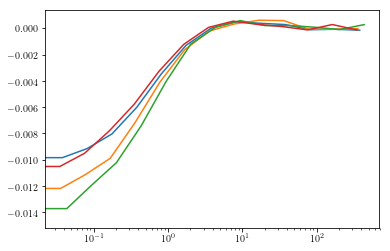

In [32]:
# Get the recombination distances and hi-lo correlations for msprime simulations of fastNeutrino-fitted models

cutoff = 5
r_list = np.insert(np.logspace(-1,3,13), 0, 0.0)
filename_fn = '../simulations/msprime/jsfs_fastNeutrino_n-{}_Chr{}_3EpochConstConst_r-{}.txt'
files_fn = {c: [filename_fn.format(n_samples,c,r) for r in r_list] for c in chromosomes}
data_fn = {c: h.import_msprime_corr(files_fn[c], n_samples) for c in chromosomes}

sfs_fn = {c: np.mean(data_fn[c][1], axis=0)/np.mean(data_fn[c][0]) for c in chromosomes}

d_fn = {c : r_list * data_fn[c][0] /2 for c in chromosomes}
hlc_fn = {c:data_fn[c][5][:,cutoff-1] for c in chromosomes}

plt.show()
for c in chromosomes:
    plt.semilogx(d_fn[c], hlc_fn[c])

In [33]:
# Get the recombination distances and hi-lo correlations for Kingman simulations
cutoff = 5

r_list_k = r_list[:-3]
head = '../simulations/msprime/jsfs_n-{}_'.format(n_samples)
files_k = [head + 'a-{}_r-{}.txt'.format(2.0, r) for r in r_list_k]

data_k = h.import_msprime_corr(files_k, n_samples)
sfs_k = np.mean(data_k[1], axis=0)/np.mean(data_k[0])

d_k = r_list_k * data_k[0] /2
hlc_k = data_k[5][:,cutoff-1]

In [34]:
from scipy import interpolate

/Users/dpr/miniconda3/envs/mmc/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log2
  after removing the cwd from sys.path.
/Users/dpr/miniconda3/envs/mmc/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.


8.147179084692096
7.731363416263832
9.37759533653021
7.520390515712439


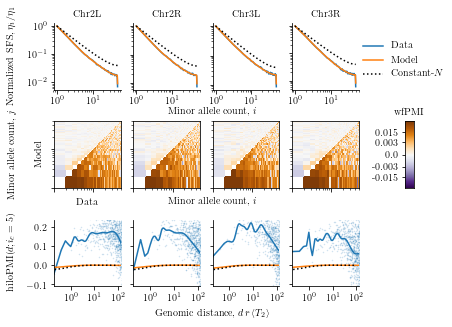

In [38]:
# Plot comparisons of data to fitted models.

# smoothing_factor = 2e-5
smoothing_factor = 4e-5
c_data = 'C0'
c_fn = 'C1'
c_k = 'k'
style_k = 'dotted'
vm_sim = 5
scale_sim = 1e-3

xscale = 1.75
yscale = 1.5
fig = plt.figure(figsize=(xscale*single_col_width, yscale*single_col_width))

x_text = 0.025 / xscale
x_panel = 0.12
x_cb = 0.9
panel_size = 0.265
panel_buffer = 0.05
panel_bottom = 0.1
panel_width = panel_size / xscale
panel_height = panel_size / yscale
panel_xbuffer = panel_buffer / xscale
panel_ybuffer = 2.5 * panel_buffer / yscale    

for i_c, c in enumerate(chromosomes):
    ax = fig.add_axes([x_panel + i_c*(panel_width+panel_xbuffer),
                      panel_bottom + 2*(panel_height+panel_ybuffer),
                      panel_width,
                      panel_height])
    x_sfs = np.arange(1, n_samples//2 + 1)
    ax.loglog(x_sfs, sfs_data[c] / sfs_data[c][0], c=c_data, label='Data')
    ax.loglog(x_sfs, sfs_fn[c] / sfs_fn[c][0], c=c_fn, label='Model')
    ax.loglog(x_sfs, ((1/x_sfs) + (1/(n_samples-x_sfs)))/ (1 + 1/(n_samples-1)), c_k, linestyle=style_k, label='Constant-$N$')
    if i_c == 3:
        ax.legend(loc=(1,0.1), frameon=False)
    if i_c != 0:
        ax.set_yticklabels([])
    ax.set_title("Chr"+c)   
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ax = fig.add_axes([x_panel + i_c*(panel_width+panel_xbuffer),
                  panel_bottom + 1*(panel_height+panel_ybuffer),
                  panel_width,
                  panel_height])
    w_data = wpmi(sfs_data[c], jsfs_data[c], n_sim)
    w_data[np.tril_indices_from(w_data)] = 0
    # Chosen to match the typical recombination rate in the data.
    i_0 = 8
    print(d_fn[c][i_0])
    w_sim = wpmi(data_fn[c][1][i_0], data_fn[c][2][i_0], n_sim)
    w_sim[np.triu_indices_from(w_sim)] = 0
    w_tot = w_data + w_sim
    wpmi_pcolor(ax, mac_sim, w_tot, scale_sim, vm_sim, cmap=cmap)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    if i_c == 0:
        # ax.set_ylabel('Minor allele count, $j$')
        ax.set_ylabel('Model')
        ax.set_xlabel('Data')
    ax = fig.add_axes([x_panel + i_c*(panel_width+panel_xbuffer),
                  panel_bottom,
                  panel_width,
                  panel_height])
    x = np.arange(3,lag_max,3)
    y = np.log2(hilo_corr4d[c][3::3]/comparisons4d[c][3::3]/(f_lo4d[c]*f_hi4d[c]))

    x = x[:len(x)]
    y = y[:len(y)]
    # Smooth on a log x-scale. Use adaptive weights
    x_sm = np.log(x)
    w = 1/x
    yinterp = interpolate.UnivariateSpline(x_sm, y, w, s=smoothing_factor)(x_sm)
    ax.semilogx(x/d_crit, y, '.', alpha=0.2, c=c_data, ms=1)
    ax.semilogx(x/d_crit, yinterp, c=c_data)
    ax.semilogx(d_fn[c], np.log2(hlc_fn[c]+1), c=c_fn)
    ax.semilogx(d_k, np.log2(hlc_k+1), c=c_k, linestyle=style_k)
    if i_c != 0:
        ax.set_yticklabels([])
    plt.ylim([-0.11,0.24])
    plt.xlim([2e-1, (1/8)*1e3])
    ax.set_xticks([1,10,100])
    ax.set_yticks([-0.1,0,0.1,0.2])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


ax = fig.add_axes([x_panel + 4*(panel_width+panel_xbuffer)+ panel_width/2,
                  panel_bottom + panel_height + panel_ybuffer,
                  0.02,
                  panel_height])
wpmi_colorbar(ax, scale_sim, vm_sim, cmap=cmap)
ax.set_title('wfPMI')

fig.text(x_text,
         panel_bottom + panel_height/2 + 2*(panel_height + panel_ybuffer),
         'Normalized SFS, $\eta_i / \eta_1$',
         va='center', rotation=90)
fig.text(x_text,
          panel_bottom + panel_height/2 + 1*(panel_height + panel_ybuffer),
          'Minor allele count, $j$',
          va='center', rotation=90)
fig.text(x_text,
         panel_bottom + panel_height/2,
         'hiloPMI$(d;i_c=5)$',
         va='center', rotation=90)

fig.text(x_panel + 2*(panel_width+panel_xbuffer),
         panel_bottom + 2*panel_height + 1.25*panel_ybuffer,
         'Minor allele count, $i$', ha='center')
fig.text(x_panel + 2*(panel_width+panel_xbuffer),
         panel_bottom + panel_height + panel_ybuffer/2,
         'Minor allele count, $i$', ha='center')

fig.text(x_panel + 2*(panel_width+panel_xbuffer),
         panel_bottom - panel_ybuffer,
         r'Genomic distance, $d\,r \left<T_2\right>$', ha='center')
fig.savefig('../manuscript/figures/dpgp3_analysis.pdf')
